In [1]:
# CIFAR-10 PCA + QDA/KNN pipeline with cross-validation and validation evaluation
# Full version and documentation: https://github.com/xyb271828/Machine-Learning.git
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# ----- config -----
DATA_PATH = "./data/train_cifar10.npz"
USE_QDA = True                 # False → KNN
RNG, VAL_SIZE, FOLDS = 42, 0.2, 5
PCA_GRID = list(range(10, 101, 10))
SHOW_SAMPLES = True
SHOW_ERRORS  = True
SHOW_REPORT  = True
LABELS = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [3]:
def show_samples(Xv,y,k=10,s=10):
    e=min(s+k,len(Xv)); plt.figure(figsize=(1.6*(e-s),1.6))
    for i,idx in enumerate(range(s,e),1):
        ax=plt.subplot(1,e-s,i); ax.imshow(Xv[idx]); ax.set_title(LABELS.get(int(y[idx]),str(int(y[idx]))),fontsize=8); ax.axis("off")
    plt.tight_layout(); plt.show()

def show_mistakes(Xv,yt,yp,m=15):
    idx=np.where(yt!=yp)[0][:m]
    if not len(idx): print("No misclassifications."); return
    r=(len(idx)+4)//5; c=min(5,len(idx)); plt.figure(figsize=(4*c,3*r))
    for i,j in enumerate(idx,1):
        ax=plt.subplot(r,c,i); ax.imshow(Xv[j])
        ax.set_title(f"T:{LABELS.get(int(yt[j]))}  P:{LABELS.get(int(yp[j]))}",fontsize=9); ax.axis("off")
    plt.tight_layout(); plt.show()

Shapes: (1000, 3072) (1000,)


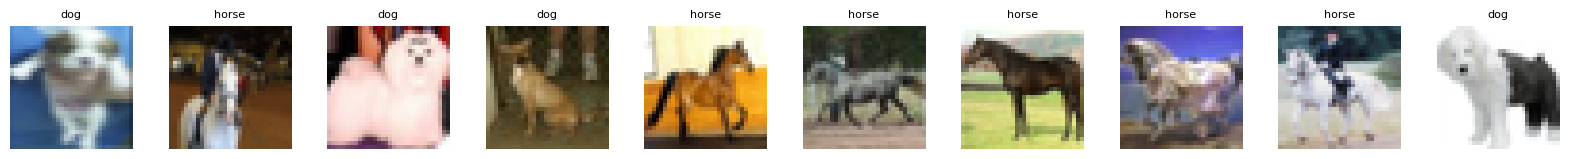

In [4]:
# ----- load & split -----
d = np.load(DATA_PATH)
X, Xv, y = d["X_train"], d["X_train_vis"], d["y_train"]
print("Shapes:", X.shape, y.shape)
X_tr, X_val, y_tr, y_val, Xv_tr, Xv_val = train_test_split(
    X, y, Xv, test_size=VAL_SIZE, stratify=y, random_state=RNG
)
if SHOW_SAMPLES: show_samples(Xv_tr, y_tr)

In [5]:
# ----- pipeline & search -----
clf = QDA() if USE_QDA else KNeighborsClassifier()
grid = {"pca__n_components": PCA_GRID} if USE_QDA else {
    "pca__n_components": PCA_GRID,
    "classifier__n_neighbors": [3,5,7,9,15],
    "classifier__weights": ["uniform","distance"],
    "classifier__p": [1,2],
}
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(whiten=False, random_state=RNG)),
    ("classifier", clf),
])
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RNG)
search = GridSearchCV(pipe, grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
search.fit(X_tr, y_tr)

print("Best params:", search.best_params_)
print("Best CV acc: {:.4f}".format(search.best_score_))

Best params: {'pca__n_components': 40}
Best CV acc: 0.7813


Validation acc: 0.7700
Classification report (val):
               precision    recall  f1-score   support

         dog       0.76      0.79      0.77        99
       horse       0.78      0.75      0.77       101

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

Confusion matrix (val):
 [[78 21]
 [25 76]]


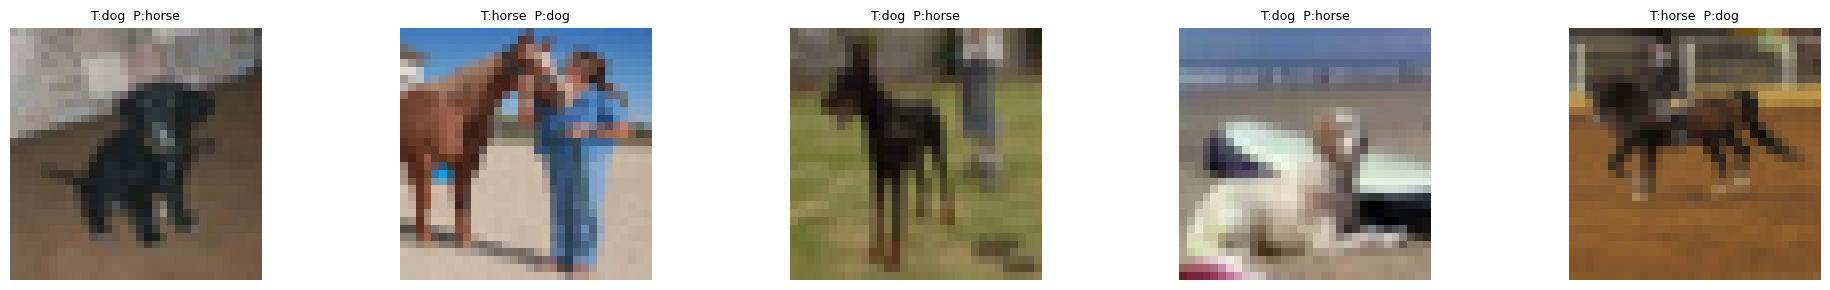

In [6]:
# ----- evaluate -----
best = search.best_estimator_
y_hat = best.predict(X_val)
val_acc = accuracy_score(y_val, y_hat)
print("Validation acc: {:.4f}".format(val_acc))

if SHOW_REPORT:
    labs=[LABELS[i] for i in sorted(np.unique(y_val))]
    print("Classification report (val):\n", classification_report(y_val, y_hat, target_names=labs))
    print("Confusion matrix (val):\n", confusion_matrix(y_val, y_hat))

if SHOW_ERRORS: show_mistakes(Xv_val, y_val, y_hat, m=5)